In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt

In [2]:
from kfac.preconditioner import KFACPreconditioner

c:\programdata\miniconda3\lib\site-packages\kfac\distributed.py:17: UserWarning: NVIDIA Apex is not installed or was not installed with --cpp_ext. Falling back to PyTorch flatten and unflatten.
  warnings.warn(


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [5]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [25]:
X_val = X_train[-5000:]
y_val = y_train[-5000:]

X_train = X_train[:-5000]
y_train = y_train[:-5000]

In [26]:
y_val 

tensor([1, 2, 8,  ..., 5, 6, 8])

In [27]:
np.bincount(y_val.numpy())

array([489, 530, 493, 509, 499, 458, 482, 563, 494, 483], dtype=int64)

In [9]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [28]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet5.parameters(), lr=0.01)
preconditioner = KFACPreconditioner(lenet5)

In [29]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(20):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        preconditioner.step()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9870)
tensor(0.9891)
tensor(0.9894)
tensor(0.9879)
tensor(0.9910)
tensor(0.9903)
tensor(0.9885)
tensor(0.9888)
tensor(0.9895)
tensor(0.9909)
tensor(0.9908)
tensor(0.9918)
tensor(0.9913)
tensor(0.9905)
tensor(0.9907)
tensor(0.9913)
tensor(0.9924)
tensor(0.9903)
tensor(0.9905)
tensor(0.9905)


In [19]:
lenet5_2 = LeNet5()
optimizer = torch.optim.SGD(lenet5_2.parameters(), lr=0.01)

In [20]:
batch_size = 100

test_accuracy_history_2 = []
test_loss_history_2 = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(20):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5_2.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5_2.forward(X_test)
    test_loss_history_2.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history_2.append(accuracy)
    
    print(accuracy)

tensor(0.8077)
tensor(0.8791)
tensor(0.9086)
tensor(0.9258)
tensor(0.9371)
tensor(0.9463)
tensor(0.9526)
tensor(0.9586)
tensor(0.9616)
tensor(0.9666)
tensor(0.9682)
tensor(0.9706)
tensor(0.9719)
tensor(0.9732)
tensor(0.9757)
tensor(0.9752)
tensor(0.9764)
tensor(0.9775)
tensor(0.9796)
tensor(0.9780)


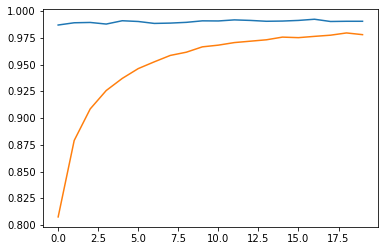

In [31]:
plt.plot(test_accuracy_history);
plt.plot(test_accuracy_history_2);

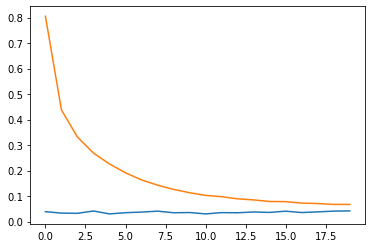

In [32]:
plt.plot(test_loss_history)
plt.plot(test_loss_history_2)